In [1]:
import keras
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential, Model, save_model, load_model
from scipy.stats import pearsonr
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.backend.tensorflow_backend import set_session
from keras import backend as K
from keras.backend import slice
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import time
import pickle

Using TensorFlow backend.


## Functions

In [2]:
def load_data(station): ## Station in String
    flow = np.load('../../usgsflow_'+station+'.npy')
    precip = np.load('../../NLDAS_precip_'+station+'.npy')
    srad = np.load('../../NLDAS_srad_'+station+'.npy')
    tmax = np.load('../../NLDAS_tmax_'+station+'.npy')
    y = np.array(flow).reshape(-1, 1)
    indx = np.where(y>=0)[0]
    # print(precip.shape)
    date = np.load('../../usgsdate_'+station+'.npy', allow_pickle=True)
    x = np.concatenate((precip, srad, tmax), axis=1)
    return x, y
def nse(y_pred, y_true):
    nse = 1-np.sum((y_pred-y_true)**2)/np.sum((y_true-np.mean(y_true))**2)
    return nse
def dataset_ld(x,y,W,L):
    obs = x.shape[0]
    features = x.shape[1]
    a = np.zeros([obs-W-L+1, W, features])
    b = np.zeros([obs-W-L+1, 1])
    for i in range(obs-W-L+1):
        a[i,:,:] = x[i:i+W,:]
        b[i,:] = y[i+W+L-1,0]    
    return a, b
def train_test_pre(x, y):
    xtrain = x[:10000]; xtest = x[10000:]
    ytrain = y[:10000]; ytest = y[10000:]
    xscale = StandardScaler().fit(xtrain)
    yscale = StandardScaler().fit(ytrain)
    Xtrain = xscale.transform(xtrain); Xtest = xscale.transform(xtest)
    Ytrain = yscale.transform(ytrain); Ytest = yscale.transform(ytest)
    return Xtrain, Xtest, Ytrain, Ytest, xscale, yscale
def custom_loss(y_true, y_pred):
    s1 = K.sum((y_pred-y_true)**2)/K.sum((y_true-K.mean(y_true))**2)
    return s1

In [3]:
def build_model(W,L):
    x_in = keras.layers.Input(shape=(W,3)) # Batch, Length, Dimension
    ## Block 1
    x_tp = keras.layers.Conv1D(kernel_size=7, filters=40, dilation_rate=1, padding='causal')(x_in)
    # x_tp = keras.layers.BatchNormalization()(x_tp)
    x_tp = keras.layers.Activation('relu')(x_tp)
    x_tp = keras.layers.Dropout(0.6)(x_tp)
    x_tp = keras.layers.Conv1D(kernel_size=7, filters=40, dilation_rate=1, padding='causal')(x_tp)
    # x_tp = keras.layers.BatchNormalization()(x_tp)
    x_tp = keras.layers.Activation('relu')(x_tp)
    x_tp = keras.layers.Dropout(0.6)(x_tp)
    ## add res for block 1
    x_res = keras.layers.Conv1D(kernel_size=1, filters=40, dilation_rate=1, padding='causal')(x_in)
    x_tp = keras.layers.Add()([x_tp, x_res])
    x_tp = keras.layers.Activation('relu')(x_tp)
    ## Block 2
    x_block1 = x_tp
    x_tp = keras.layers.Conv1D(kernel_size=7, filters=20, dilation_rate=6, padding='causal')(x_tp)
    # x_tp = keras.layers.BatchNormalization()(x_tp)
    x_tp = keras.layers.Activation('relu')(x_tp)
    x_tp = keras.layers.Dropout(0.6)(x_tp)
    x_tp = keras.layers.Conv1D(kernel_size=7, filters=20, dilation_rate=6, padding='causal')(x_tp)
    # x_tp = keras.layers.BatchNormalization()(x_tp)
    x_tp = keras.layers.Activation('relu')(x_tp)
    x_tp = keras.layers.Dropout(0.6)(x_tp)
    ## add res for block 2
    x_res = keras.layers.Conv1D(kernel_size=1, filters=20, dilation_rate=1, padding='causal')(x_block1)
    x_tp = keras.layers.Add()([x_tp, x_res])
    # x_tp = keras.layers.Add()([x_tp, x_block1])
    x_tp = keras.layers.Activation('relu')(x_tp)    
    ## Block 3
    x_block2 = x_tp
    x_tp = keras.layers.Conv1D(kernel_size=7, filters=20, dilation_rate=12, padding='causal')(x_tp)
    # x_tp = keras.layers.BatchNormalization()(x_tp)
    x_tp = keras.layers.Activation('relu')(x_tp)
    x_tp = keras.layers.Dropout(0.6)(x_tp)
    x_tp = keras.layers.Conv1D(kernel_size=7, filters=20, dilation_rate=12, padding='causal')(x_tp)
    # x_tp = keras.layers.BatchNormalization()(x_tp)
    x_tp = keras.layers.Activation('relu')(x_tp)
    x_tp = keras.layers.Dropout(0.6)(x_tp)
    ## add res for block 3
    # x_res = keras.layers.Conv1D(kernel_size=1, filters=20, dilation_rate=1, padding='causal')(x_block2)
    # x_tp = keras.layers.Add()([x_tp, x_res])
    x_tp = keras.layers.Add()([x_tp, x_block2])
    x_tp = keras.layers.Activation('relu')(x_tp)
    ## SLICE
    x_tp = keras.layers.Lambda(lambda x:slice(x,(0,80,0),(-1,-1,-1)))(x_tp) # batch, length, channels 
    x_tp = keras.layers.Flatten()(x_tp)
    x_tp = keras.layers.Dropout(0.5)(x_tp)
    x_tp = keras.layers.Dense(100, activation='relu')(x_tp)
    x_tp = keras.layers.Dropout(0.5)(x_tp)
    x_out = keras.layers.Dense(1)(x_tp)
    model = Model(inputs=x_in, outputs=x_out)
    return model

## Constants

In [4]:
lr = 0.0005; W=365; L=0;
f = open('../../../StationArea.pkl','rb')
areas = pickle.load(f); f.close()

../CNN/10258500_DCNN.h5




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


(9497, 1)   (9497, 1)
(9497, 3)
(9497, 1)   (9497, 1)
(9497, 3)
(9498, 1)   (9497, 1)
(9497, 3)
(9497, 1)   (9497, 1)
(9497, 3)


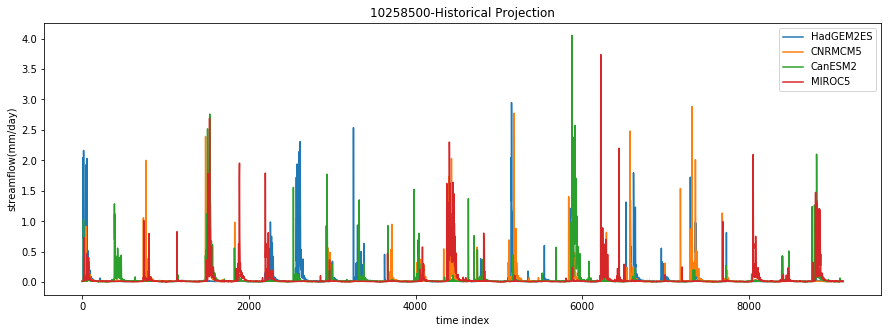

../CNN/10259000_DCNN.h5
(9497, 1)   (9497, 1)
(9497, 3)
(9497, 1)   (9497, 1)
(9497, 3)
(9498, 1)   (9497, 1)
(9497, 3)
(9497, 1)   (9497, 1)
(9497, 3)


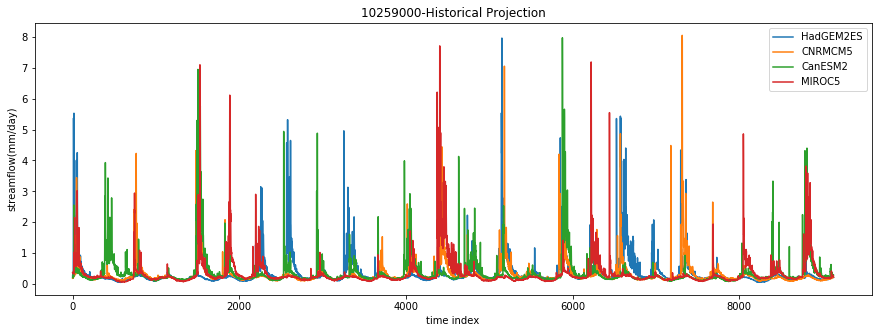

../CNN/10259200_DCNN.h5
(9497, 1)   (9497, 1)
(9497, 3)
(9497, 1)   (9497, 1)
(9497, 3)
(9498, 1)   (9497, 1)
(9497, 3)
(9497, 1)   (9497, 1)
(9497, 3)


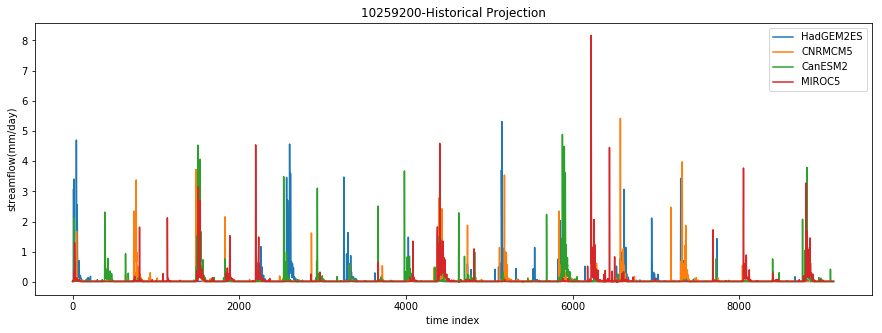

../CNN/10343500_DCNN.h5
(9497, 1)   (9497, 1)
(9497, 3)
(9497, 1)   (9497, 1)
(9497, 3)
(9498, 1)   (9497, 1)
(9497, 3)
(9497, 1)   (9497, 1)
(9497, 3)


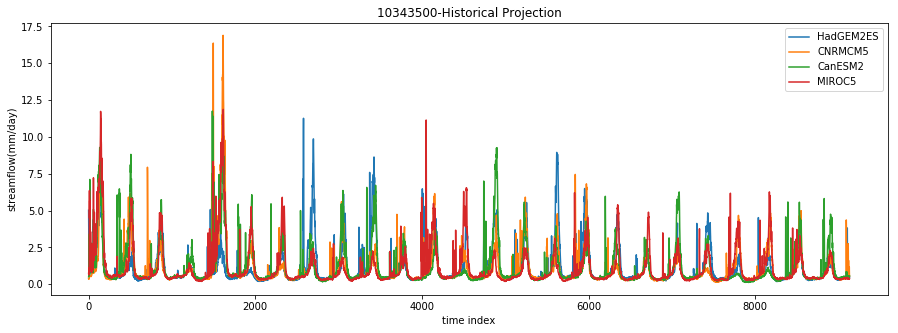

../CNN/11141280_DCNN.h5
(9497, 1)   (9497, 1)
(9497, 3)
(9497, 1)   (9497, 1)
(9497, 3)
(9498, 1)   (9497, 1)
(9497, 3)
(9497, 1)   (9497, 1)
(9497, 3)


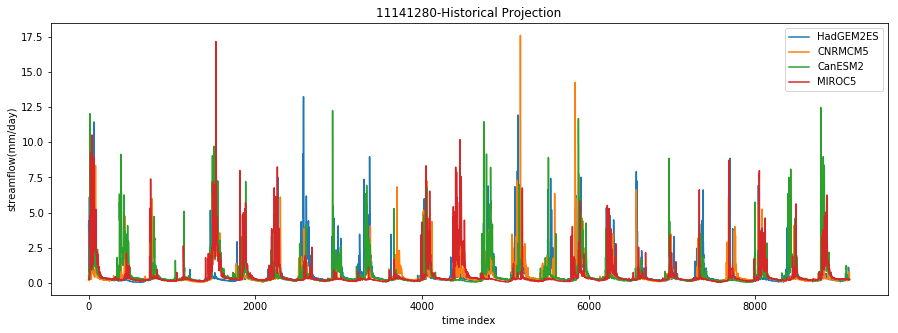

../CNN/11143000_DCNN.h5
(9497, 1)   (9497, 1)
(9497, 3)
(9497, 1)   (9497, 1)
(9497, 3)
(9498, 1)   (9497, 1)
(9497, 3)
(9497, 1)   (9497, 1)
(9497, 3)


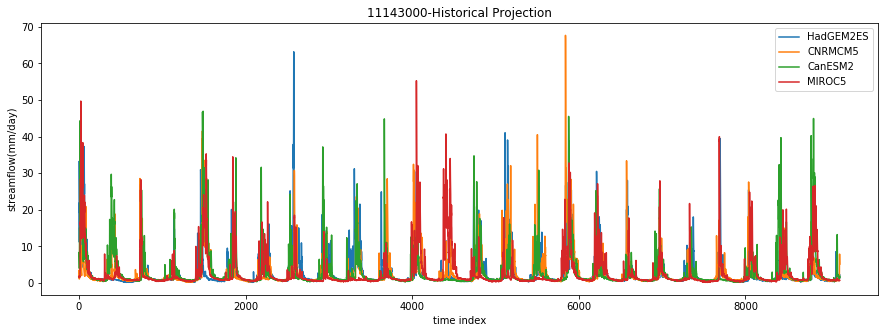

../CNN/11148900_DCNN.h5
(9497, 1)   (9497, 1)
(9497, 3)
(9497, 1)   (9497, 1)
(9497, 3)
(9498, 1)   (9497, 1)
(9497, 3)
(9497, 1)   (9497, 1)
(9497, 3)


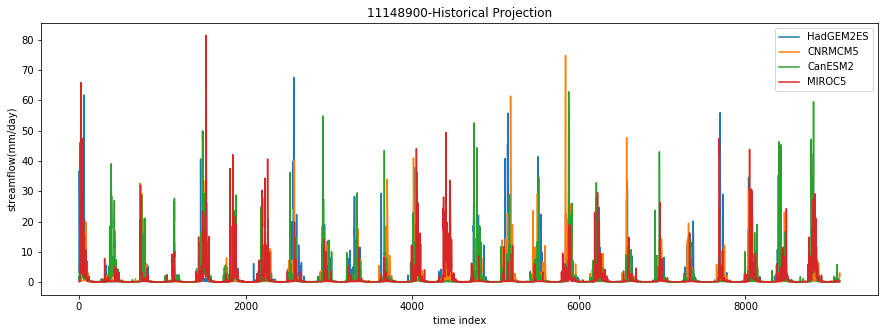

../CNN/11162500_DCNN.h5
(9497, 1)   (9497, 1)
(9497, 3)
(9497, 1)   (9497, 1)
(9497, 3)
(9498, 1)   (9497, 1)
(9497, 3)
(9497, 1)   (9497, 1)
(9497, 3)


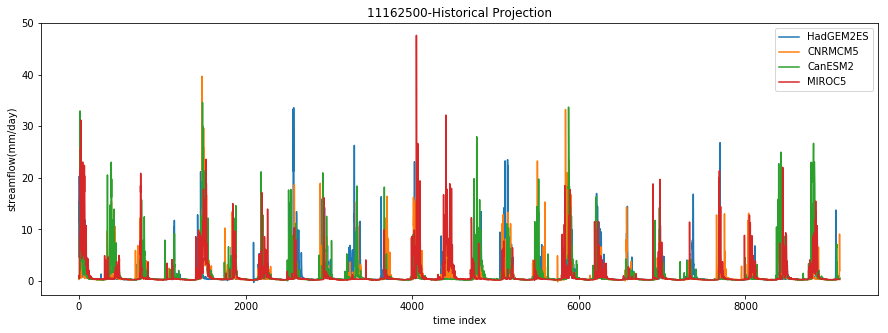

../CNN/11176400_DCNN.h5
(9497, 1)   (9497, 1)
(9497, 3)
(9497, 1)   (9497, 1)
(9497, 3)
(9498, 1)   (9497, 1)
(9497, 3)
(9497, 1)   (9497, 1)
(9497, 3)


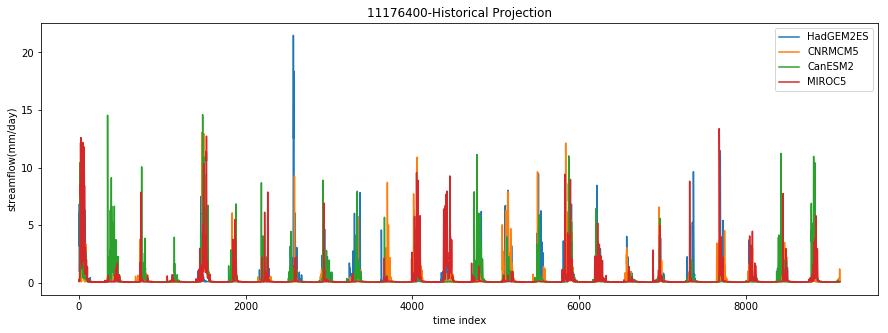

../CNN/11180500_DCNN.h5
(9497, 1)   (9497, 1)
(9497, 3)
(9497, 1)   (9497, 1)
(9497, 3)
(9498, 1)   (9497, 1)
(9497, 3)
(9497, 1)   (9497, 1)
(9497, 3)


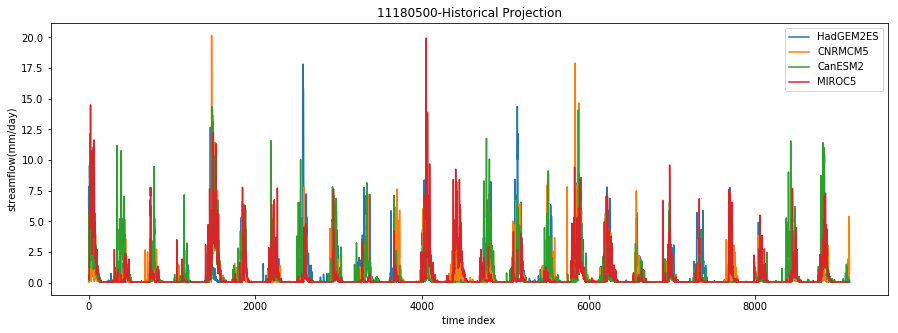

../CNN/11224500_DCNN.h5
(9497, 1)   (9497, 1)
(9497, 3)
(9497, 1)   (9497, 1)
(9497, 3)
(9498, 1)   (9497, 1)
(9497, 3)
(9497, 1)   (9497, 1)
(9497, 3)


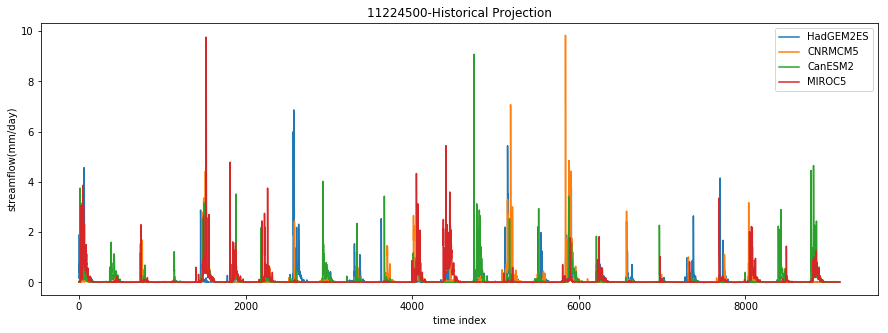

../CNN/11253310_DCNN.h5
(9497, 1)   (9497, 1)
(9497, 3)
(9497, 1)   (9497, 1)
(9497, 3)
(9498, 1)   (9497, 1)
(9497, 3)
(9497, 1)   (9497, 1)
(9497, 3)


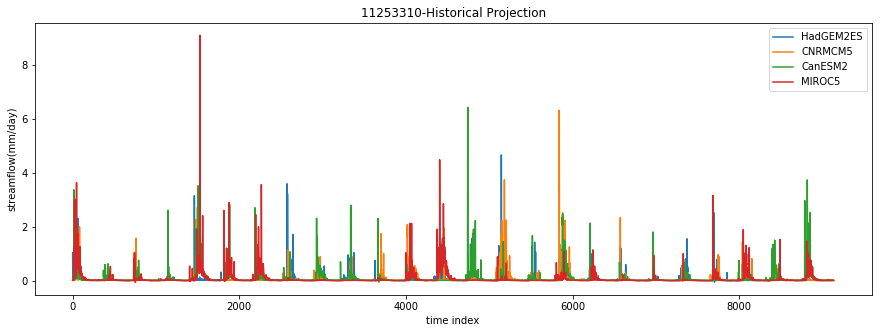

../CNN/11264500_DCNN.h5
(9497, 1)   (9497, 1)
(9497, 3)
(9497, 1)   (9497, 1)
(9497, 3)
(9498, 1)   (9497, 1)
(9497, 3)
(9497, 1)   (9497, 1)
(9497, 3)


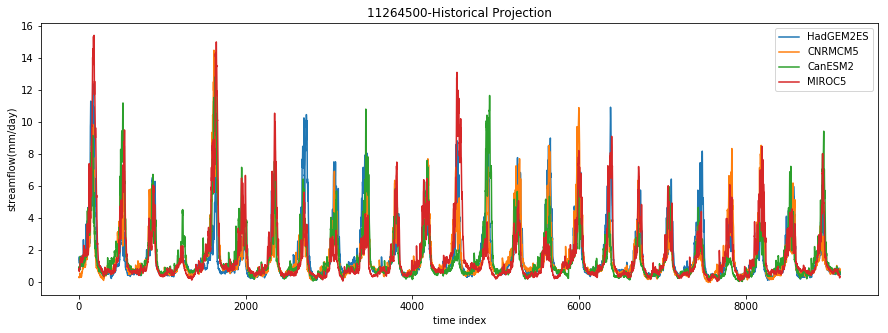

../CNN/11266500_DCNN.h5
(9497, 1)   (9497, 1)
(9497, 3)
(9497, 1)   (9497, 1)
(9497, 3)
(9498, 1)   (9497, 1)
(9497, 3)
(9497, 1)   (9497, 1)
(9497, 3)


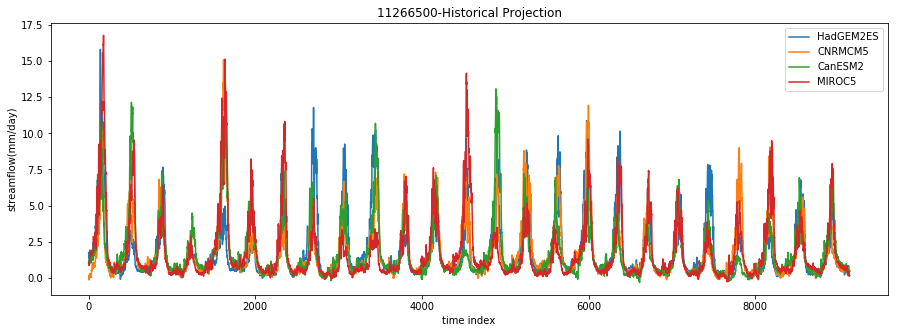

../CNN/11284400_DCNN.h5
(9497, 1)   (9497, 1)
(9497, 3)
(9497, 1)   (9497, 1)
(9497, 3)
(9498, 1)   (9497, 1)
(9497, 3)
(9497, 1)   (9497, 1)
(9497, 3)


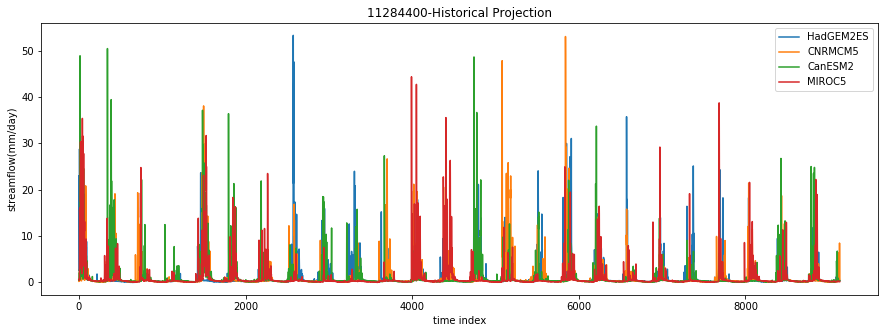

../CNN/11381500_DCNN.h5
(9497, 1)   (9497, 1)
(9497, 3)
(9497, 1)   (9497, 1)
(9497, 3)
(9498, 1)   (9497, 1)
(9497, 3)
(9497, 1)   (9497, 1)
(9497, 3)


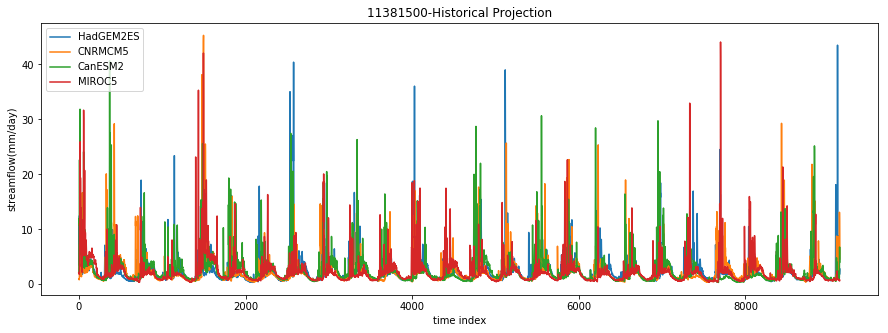

../CNN/11451100_DCNN.h5
(9497, 1)   (9497, 1)
(9497, 3)
(9497, 1)   (9497, 1)
(9497, 3)
(9498, 1)   (9497, 1)
(9497, 3)
(9497, 1)   (9497, 1)
(9497, 3)


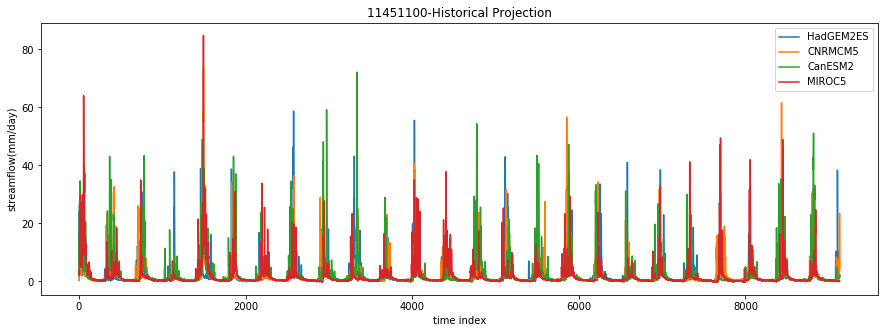

../CNN/11475560_DCNN.h5
(9497, 1)   (9497, 1)
(9497, 3)
(9497, 1)   (9497, 1)
(9497, 3)
(9498, 1)   (9497, 1)
(9497, 3)
(9497, 1)   (9497, 1)
(9497, 3)


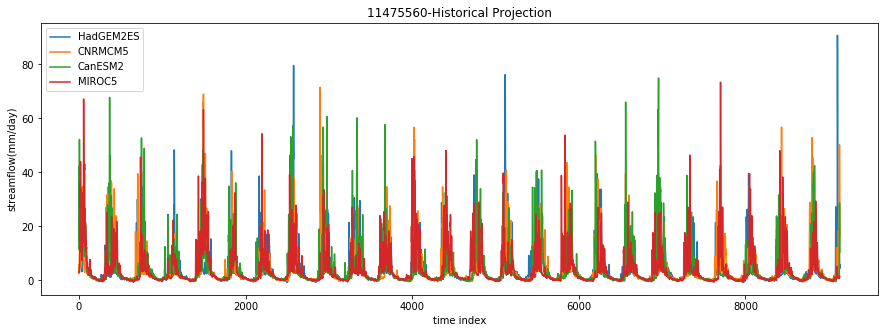

../CNN/11522500_DCNN.h5
(9497, 1)   (9497, 1)
(9497, 3)
(9497, 1)   (9497, 1)
(9497, 3)
(9498, 1)   (9497, 1)
(9497, 3)
(9497, 1)   (9497, 1)
(9497, 3)


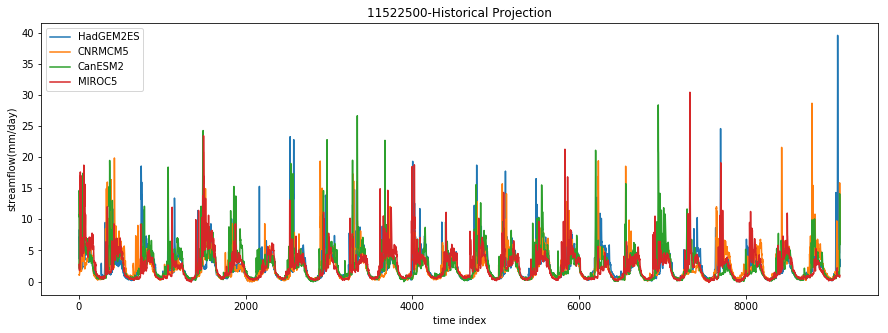

../CNN/11528700_DCNN.h5
(9497, 1)   (9497, 1)
(9497, 3)
(9497, 1)   (9497, 1)
(9497, 3)
(9498, 1)   (9497, 1)
(9497, 3)
(9497, 1)   (9497, 1)
(9497, 3)


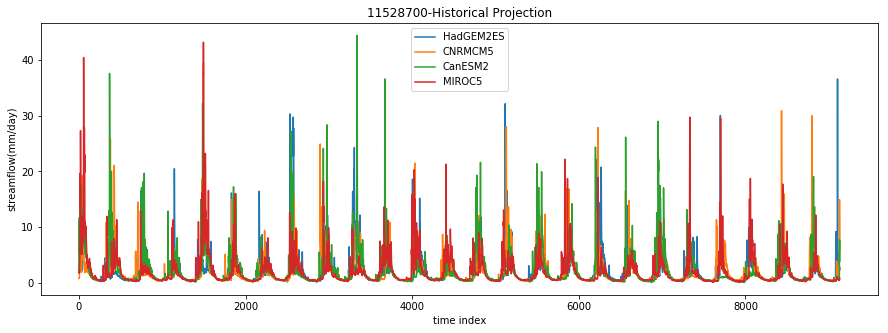

In [5]:
stations = np.load('../../first-stations.npy')
climate_models = ['HadGEM2ES', 'CNRMCM5', 'CanESM2', 'MIROC5']
regrid_path = '/tempest/duan0000/flow/tem-remap/regrid_out/'
## Projection for one station
station = 11528700
for station in stations:
    model_name = '../CNN/'+str(station)+'_DCNN.h5' ## best model
    print(model_name)
    model=build_model(W, L)
    adam = keras.optimizers.Adam(lr=lr)
    model.compile(loss=custom_loss, optimizer=adam)
    model.load_weights(model_name)
    ## load data.
    x, y = load_data(str(station))
    area = areas[str(station)]
    ## Transform to Runoff
    y = y*86400*1000/(area*1000*1000)
    Xtrain, Xtest, Ytrain, Ytest, xscale, yscale = train_test_pre(x, y)
    '''
    X_train, Y_train = dataset_ld(Xtrain, Ytrain, W, L)
    X_test, Y_test = dataset_ld(Xtest, Ytest, W, L)
    Y_pred = model.predict(X_test)
    y_pred = yscale.inverse_transform((Y_pred).reshape(-1, 1))
    y_true = yscale.inverse_transform((Y_test).reshape(-1, 1))
    '''
    ## Projection
    fig = plt.figure(figsize=(15,5))
    for climate_model in climate_models:
        p_85 = np.load(regrid_path+str(station)+'_'+climate_model+'_p_hist.npy').reshape(-1, 1)
        t_85 = np.load(regrid_path+str(station)+'_'+climate_model+'_t_hist.npy').reshape(-1, 1)
        rs_85 = np.load(regrid_path+str(station)+'_'+climate_model+'_rs_hist.npy').reshape(-1, 1)
        print(rs_85.shape, ' ', p_85.shape)
        rs_85 = rs_85[:p_85.shape[0]]
        x_proj = np.concatenate((p_85, rs_85, t_85), axis=1)
        print(x_proj.shape)
        Xproj = xscale.transform(x_proj)    
        X_proj, _ = dataset_ld(Xproj, Xproj, W, L)
        Y_proj = model.predict(X_proj)
        y_proj = yscale.inverse_transform((Y_proj).reshape(-1, 1))
        np.save('projection_dataset/'+str(station)+'-'+climate_model+'-hist', y_proj)
        ## plot
        plt.plot(y_proj, label=climate_model)
    plt.legend()
    plt.xlabel('time index')
    plt.ylabel('streamflow(mm/day)')
    plt.title(str(station)+'-Historical Projection')
    plt.show()